# Классификация комментариев по работе управляющей компании

Этот ноутбук предназначен для разработки и обучения модели машинного обучения для классификации комментариев пользователей по различным категориям, связанным с работой управляющей компании.


In [ ]:
# Установка основных библиотек
# !pip install pandas scikit-learn nltk matplotlib seaborn -q

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Попытка загрузить ресурсы nltk без вывода ошибок, если они уже есть
for resource in ["corpora/stopwords", "tokenizers/punkt"]:
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split("/")[-1], quiet=True)

# Теперь можно безопасно получить русские стоп-слова
russian_stopwords = stopwords.words("russian")
print(f"Загружено {len(russian_stopwords)} русских стоп-слов.")

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier  # Для мультилейбл классификации
from sklearn.metrics import roc_auc_score, hamming_loss, classification_report, f1_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

Загружено 151 русских стоп-слов.


## 2. Загрузка обработанных данных

In [2]:
data_path = 'processed_data_new.csv' 
try:
    df = pd.read_csv(data_path)
    print("Данные успешно загружены.")
    print(f"Размер датасета: {df.shape}")
    df["comment"] = df["comment"].astype(str).fillna("") # Убедимся, что комментарии - строки и NaN заменены
    print("Первые 5 строк данных:")
    print(df.head())
except FileNotFoundError:
    print(f"Файл не найден по пути: {data_path}. Убедитесь, что путь указан верно и файл существует.")
    df = None 
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    df = None

Данные успешно загружены.
Размер датасета: (1862, 9)
Первые 5 строк данных:
                                        comment       id  rating  \
0                                       спасибо  2945792       5   
1                                      спасибо!  3234340       5   
2                                      Отлично   3380332       5   
3  Благодарю за оперативное решение проблемы !   3381812       5   
4         Прекрасный специалист! Побольше таких  3461991       5   

   Вопрос решен  Нравится качество выполнения заявки  \
0             1                                    0   
1             1                                    0   
2             1                                    0   
3             1                                    0   
4             1                                    0   

   Нравится качество работы сотрудников  Нравится скорость отработки заявок  \
0                                     0                                   0   
1                   

Используемые категории для обучения и оценки: ['Вопрос решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки', 'Ничего из перечисленного']


/tmp/ipykernel_18187/1591468989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


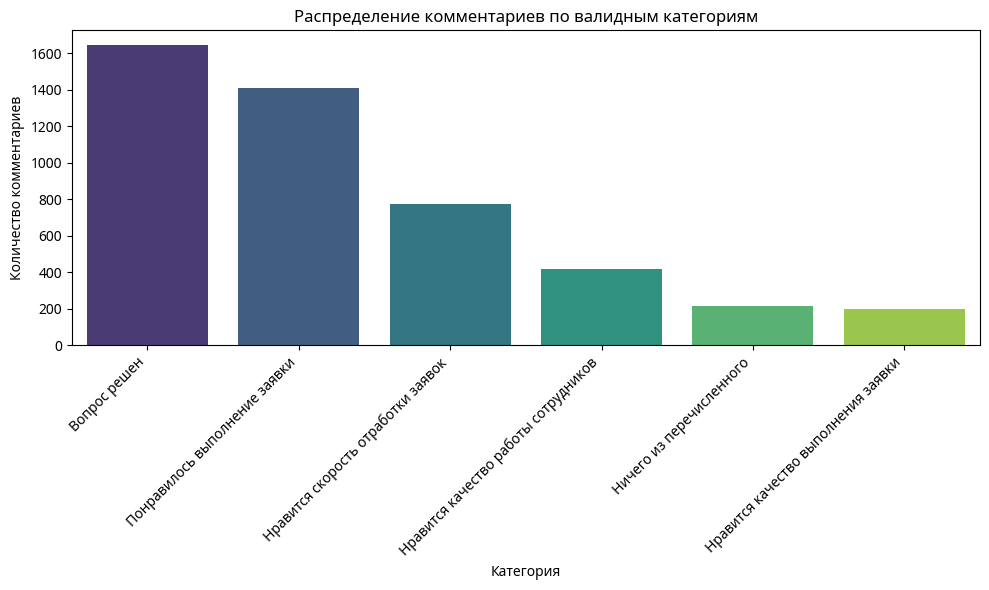

Распределение по валидным категориям:
Вопрос решен                            1642
Понравилось выполнение заявки           1409
Нравится скорость отработки заявок       775
Нравится качество работы сотрудников     417
Ничего из перечисленного                 216
Нравится качество выполнения заявки      199
dtype: int64


In [3]:
initial_category_cols = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Ничего из перечисленного'
 ]

# Фильтрация категорий, имеющих более одного уникального значения (т.е. не только 0 или только 1)
valid_category_cols = []
for col in initial_category_cols:
    if col in df.columns and df[col].nunique() > 1:
        valid_category_cols.append(col)
    else:
        print(f"Категория {col} была исключена, так как содержит только один класс или отсутствует в данных.")

if not valid_category_cols:
    raise ValueError("Нет валидных категорий для обучения после фильтрации. Проверьте данные.")

print(f"Используемые категории для обучения и оценки: {valid_category_cols}")

# Подсчет количества комментариев по валидным категориям
category_counts = df[valid_category_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Распределение комментариев по валидным категориям')
plt.xlabel('Категория')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Распределение по валидным категориям:")
print(category_counts)


Предобработка текста комментариев


In [4]:
stop_words_russian = stopwords.words('russian')

def preprocess_text(text):
    text = str(text).lower()  # Приведение к нижнему регистру
    text = re.sub(r'\s+[а-я]{1,2}\s+', ' ', text) # Удаление коротких предлогов/союзов (очень грубо)
    text = re.sub(r'[^а-яА-ЯёЁ0-9\s]', ' ', text)  # Удаление пунктуации и спецсимволов, оставляем только кириллицу, цифры и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    tokens = text.split() # Замена word_tokenize для русского языка
    tokens = [word for word in tokens if word not in stop_words_russian and len(word) > 2] # Удаление стоп-слов и коротких слов
    return ' '.join(tokens)

# Применение предобработки к столбцу 'comment'
# Убедимся, что столбец 'comment' существует и не пустой
if 'comment' in df.columns:
    df['processed_comment'] = df['comment'].apply(preprocess_text)
    print("Пример обработанного комментария:")
    if not df.empty and 'comment' in df and 'processed_comment' in df:
        print(f"Оригинал: {df['comment'].iloc[0]}")
        print(f"Обработанный: {df['processed_comment'].iloc[0]}")
        print("Первые 5 строк с обработанными комментариями:")
        print(df[['comment', 'processed_comment']].head())
    else:
        print("DataFrame пуст или отсутствуют необходимые столбцы для вывода примера.")
else:
    print("Столбец 'comment' не найден в DataFrame.")


Пример обработанного комментария:
Оригинал: спасибо
Обработанный: спасибо
Первые 5 строк с обработанными комментариями:
                                        comment  \
0                                       спасибо   
1                                      спасибо!   
2                                      Отлично    
3  Благодарю за оперативное решение проблемы !    
4         Прекрасный специалист! Побольше таких   

                        processed_comment  
0                                 спасибо  
1                                 спасибо  
2                                 отлично  
3  благодарю оперативное решение проблемы  
4    прекрасный специалист побольше таких  


## Разделение данных на признаки (X) и целевые переменные (y)


In [5]:
X = df['processed_comment']
y = df[valid_category_cols] # Используем только валидные категории

print(f"Размер X: {X.shape}")
print(f"Размер y: {y.shape}")


Размер X: (1862,)
Размер y: (1862, 6)


In [ ]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import os

# Загружаем датасет
df = pd.read_csv("processed_data_new.csv")

target_columns = [
    "Вопрос решен",
    "Нравится качество выполнения заявки",
    "Нравится качество работы сотрудников",
    "Нравится скорость отработки заявок",
    "Понравилось выполнение заявки",
    "Ничего из перечисленного"
]
text_column = "comment"
df[text_column] = df[text_column].fillna("")

# --- 1. Распределение классов ---
print("График распределения классов:")
plt.figure(figsize=(12, 8))
df[target_columns].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество комментариев')
plt.xlabel('Категории')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()   # Показываем в ноутбуке

# --- Обучение и предсказания ---
X = df[text_column]
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000)),
    ("clf", OneVsRestClassifier(LogisticRegression(solver="liblinear", random_state=42)))
])

print("\nОбучение модели...")
model_pipeline.fit(X_train, y_train)
print("Обучение завершено.")

print("\nПредсказания...")
y_pred_proba = model_pipeline.predict_proba(X_test)
print("Готово.")

# --- 2. ROC-кривые ---
print("\nROC-кривые:")
plt.figure(figsize=(12, 10))
roc_auc_scores = {}
for i, label in enumerate(target_columns):
    if len(np.unique(y_test[label])) > 1:
        fpr, tpr, _ = roc_curve(y_test[label], y_pred_proba[:, i])
        roc_auc = roc_auc_score(y_test[label], y_pred_proba[:, i])
        roc_auc_scores[label] = roc_auc
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
        print(f"  {label}: {roc_auc:.4f}")
    else:
        print(f"  {label}: нельзя вычислить (только один класс)")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривые по категориям')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()   # Показываем ROC-кривые

average_roc_auc = np.nanmean(list(roc_auc_scores.values()))
print(f"\nСредний ROC-AUC (макро): {average_roc_auc:.4f}")


Генерация графика распределения классов...
График распределения классов сохранён в /home/ubuntu/plots/class_distribution.png

Обучение модели...


Обучение модели завершено.

Выполнение предсказаний...
Предсказания выполнены.

Генерация графика ROC-кривых...
ROC-AUC для Вопрос решен: 0.9762
ROC-AUC для Нравится качество выполнения заявки: 0.8262
ROC-AUC для Нравится качество работы сотрудников: 0.8537
ROC-AUC для Нравится скорость отработки заявок: 0.9360
ROC-AUC для Понравилось выполнение заявки: 0.9071
ROC-AUC для Ничего из перечисленного: 0.9769


График ROC-кривых сохранён в /home/ubuntu/plots/roc_curves.png

Средний ROC-AUC (макро): 0.9127

Скрипт с построением графиков завершён.
